# Evolution including Virus Family hybrid Clustering based on artificially mutated K-mers

## Milestones

- [x] HDBSCAN github errors
    - need to find version without problems
    - if now finding one revert back to MA version
    - revert back to Masterthesis and update jupyter lab, git and ressource
- [x] better inclusion of R, N, ... in the kmer
    - implemented, maybe need adjustment by value
    - if frature of missing higher than threshold garbage
    - if not fill missing by possible constellations
- [x] evolution on reading frame
    - difficult with amino conservation ORF tracker necessary
        - e.g. BLOSUM etc.
    - nucleotide exchange values used now, instead of amino exchange
        - usage of Kimura's two-parameter model
        - alpha and beta of user choice
- [ ] stable parameters 
    - best would be algorithmic solution here
        - number of clusters
            - neighbors -> distance matrix -> kneedle algorithm -> epsilon
        - sample number
            - cluster number extraction algorithms -> sample 
    - alpha value (A -> G, C -> T)
    - beta value (...)
    - for more flexibility algorithmis solution was postponed to a later release

- [ ] global local hybrid clustering (GLHC)
    - idea war rejected first due to the necessary nxn space in worst case
    - maybe precalculation reinclude into clustering in the first place useful at some point
        - precalculation: nxn
        - no precalculation: nxk 
        - could be usefull in the future to change to precalculation
        - necessary for this step is the stepwise calculation of the precalc matrix
            - d(acc1, acc2), d(acc1, acc3), d(acc1, acc4), ..., d(acc1, accn)
            - d(acc2, ....) find a way to calculate the rest based on the first line
    - centroids -> single linkage(centroids)
        - difficulat to validate the quality of this method
    - all point cluster distance (apcd) instead of centroids
- [ ] k-mer implementation by taking only existing values into account
    - copy and update the old code from the project

## Implementation Blueprint

![Class2](Clusterer.svg)

## Packages

### Clustering

In [1]:
import numpy as np
import pandas as pd
import itertools as it
from Bio import SeqIO
from Bio.Seq import Seq
import math
import re
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import multiprocessing as mp
import umap
import hdbscan
import scipy.spatial.distance as ssd
from scipy.cluster import hierarchy
from tqdm import tqdm

### Tree

In [2]:
import collections as co
import seaborn as sns
from ete3 import PhyloTree, Tree, faces, AttrFace, CircleFace, TreeStyle, NodeStyle, TextFace, RectFace, SequenceFace
from matplotlib import colors
from natsort import natsorted
import random
import os
#os.environ['QT_QPA_PLATFORM'] = 'offscreen'

### 3D Plot

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

### Alignment

In [4]:
from io import StringIO
from Bio import AlignIO
from Bio.Align.Applications import MafftCommandline
from IPython.display import display

## Classes and Definitions

### Clustering

In [5]:
class Vectors(object):
    
    def __init__(self, k = 7, identifier = 0, split = None, quality = {'':0}, variable = 2, state = 1.0, alpha = 0.0, beta = 0.0, init = 0.0, procs = 4, preprocess = True):
    
        self.k = k
        self.quality = quality
        self.identifier = identifier
        self.split = split
        self.variable = variable
        self.nucleotides = ['A', 'C', 'G', 'T']
        self.purines = ['A', 'G']
        self.pyrines = ['C', 'T']
        self.exotics = ['R', 'Y', 'W', 'S', 'M', 'K', 'B', 'H', 'D', 'V', 'N']
        #self.substit = dict.fromkeys(map(ord, self.nucleotides), None)
        #self.exist = dict.fromkeys(map(''.join, it.product(self.nucleotides, repeat = self.k)), init)        
        self.state = state
        self.init = init
        self.procs = procs
        self.alpha = alpha
        self.beta = beta
        self.preprocess = preprocess
        self.exchange = {
            'A':['A'],
            'C':['C'],
            'G':['G'],
            'T':['T'],
            'R':['A', 'G'],
            'Y':['C', 'T'],
            'W':['A', 'T'],
            'S':['C', 'G'],
            'M':['A', 'C'],
            'K':['G', 'T'],
            'B':['G', 'C', 'T'],
            'H':['A', 'C', 'T'],
            'D':['A', 'G', 'T'],
            'V':['A', 'C', 'G'],
            'N':['A', 'C', 'G', 'T'],
        } 
        self.kimura = {}
        for nuc in self.nucleotides:
            self.kimura[nuc] = {}
            if self.alpha != 0.0: 
                a = self.purines if nuc in self.purines else self.pyrines
                pos = 0 if a.index(nuc) != 0 else 1
                self.kimura[nuc][a[pos]] = self.alpha
            if self.beta != 0.0:
                b = self.purines if nuc not in self.purines else self.pyrines
                self.kimura[nuc][b[0]] = self.beta
                self.kimura[nuc][b[1]] = self.beta
    
    def countRows(self, infile):
        
        index = []
        record = SeqIO.index(infile, "fasta", key_function = lambda entry: entry.split(self.split)[self.identifier] if type(self.identifier) == int else re.search('.*' + self.identifier + '([^|]+).*', entry)[1])
        for accession in record.keys():
            
            entry = record[accession]
            header = entry.description.split(self.split)
            sequence = str(entry.seq)
            #missing = len(sequence.translate(self.substit))
            #fracture = float(len(sequence)/missing) if missing else 0 
            missing = re.findall('['+''.join(self.exotics)+']+', sequence)
            
            try:
                if all([re.match(i, header[self.quality[i]], re.IGNORECASE) for i in self.quality]) == True and (0 if not missing else len(max(missing, key=len))) <= self.variable:
                #if all([re.match(i, header[self.quality[i]], re.IGNORECASE) for i in self.quality]) == True and fracture <= 0.9:
                    index.append(accession)
            except:
                pass
        
        return(index, record)
    
    def preprocessKmer(self, sequence):
        
        exist = []
        for i in range(len(sequence) - self.k + 1):
            kmer = sequence[i:i+self.k]
            main = list(map(''.join, it.product(*[self.exchange.get(j) for j in kmer])))

            for sub in main:
                exist.append(sub)
                #if self.kimura:
                #    for l, nuc in enumerate(sub):
                #        for mut in self.kimura[nuc].keys():
                #            mutation = sub[:l] + mut + sub[l+1:]
                            #self.exist[sub] = 0
                #            exist.append(mutation)

        return(exist)
    
    def calculateKmer(self, data):
        
        temporary, sequence = data
        
        for i in range(len(sequence) - self.k + 1):
            kmer = sequence[i:i+self.k]
            main = list(map(''.join, it.product(*[self.exchange.get(j) for j in kmer])))

            for sub in main:
                temporary[sub] += self.state/len(main)
                if self.kimura:
                    for l, nuc in enumerate(sub):
                        for mut in self.kimura[nuc].keys():
                            mutation = sub[:l] + mut + sub[l+1:]
                            if mutation in temporary:
                                temporary[mutation] += self.kimura[nuc][mut]

        vector = np.fromiter(temporary.values(), dtype = 'float32', count = len(temporary.keys()))/sum(temporary.values())
        temporary.clear()
        return(vector)
        
    def calculateFrequence(self, infile):
        
        index, record = self.countRows(infile)
        #matrix = np.empty((len(index), self.col, ),dtype = 'float32')
        
        if self.preprocess == True:
            with mp.Pool(self.procs) as pool:
                preprocessor = tqdm(pool.imap(self.preprocessKmer, map(lambda m: str(record[m].seq), index)), total = len(index), desc="Preprocessing")
                exist = dict(sorted(dict.fromkeys(it.chain.from_iterable(preprocessor), self.init).items()))

        else:
            exist = dict.fromkeys(map(''.join, it.product(self.nucleotides, repeat = self.k)), self.init)    
                
        shared = it.repeat(exist,len(index))
        
        with mp.Pool(self.procs) as pool:
            calculator = tqdm(pool.imap(self.calculateKmer, zip(shared, map(lambda m: str(record[m].seq), index))), total = len(index), desc="Calculation")
            matrix = np.fromiter(it.chain.from_iterable(calculator), dtype = 'float32', count = len(exist.keys()) * len(index))
            matrix.shape = len(index), len(exist.keys())
            #for pos, vector in enumerate(calculator):
            #    matrix[pos] = vector
                
        return(index, matrix)

- execution can still be faster ca. 15-20min for segment 4 is still slow, lul now its 2 at max
    - inclusion of mutation increased the runtime by factor 5-10, nvm multipressing easy
    - multiprocessing difficult to implement (dicts, fast calculation of single instances high overhang)
- all mutations and all unkown kmers (including e.g. Ns) are counted with state or respective alpha beta
    - maybe split value by their number

In [6]:
def Cluster(linkage, min_clust, num_clust):

    x = 0.0
    y = 1.0
    cluster = linkage.get_clusters(cut_distance = x, min_cluster_size = min_clust)
    n = cluster.max().item()
    
    while n != num_clust:

        if n < num_clust and n != -1:
            x = x - y
            y = y * 0.1

        else:
            x = x + y

        cluster = linkage.get_clusters(cut_distance = x, min_cluster_size = min_clust)
        n = cluster.max().item()
        
        if x != 0.0 and n == -1:
            print('Error.')
            break
        
    return(cluster)

In [7]:
def workerCentroid(subtuple):
    
    subl2, i = subtuple
    indexdist = subl2.index.tolist()
    calcdist = map(lambda x: ssd.cdist([x[1]], subl2, 'euclidean').mean(), subl2.iterrows())
    framedist = pd.DataFrame(np.fromiter(calcdist, dtype = 'float32', count = len(subl2)), index = indexdist)
    return(framedist.idxmin().item(), i)

In [8]:
def Centroid(framecluster, framel2):
    
    groups = framecluster.query('cluster != -1').groupby('cluster').groups
    
    with mp.Pool(procs) as pool:
        result = pool.imap(workerCentroid, map(lambda match: (framel2.loc[groups[match]], match), groups.keys()))
        centroid = pd.DataFrame(result, columns = ['accession', 'cluster']).set_index('accession')
        
    return(centroid)

In [9]:
def Linkage(framecentroid, framel2, procs):
    
    subl2 = framel2.loc[framecentroid.index.tolist()]
    distance = ssd.cdist(subl2, subl2, 'euclidean')
    linkage = hierarchy.linkage(distance, method = 'single', metric = 'euclidean')
    
    return(linkage, distance)

### Tree

In [10]:
def getNewick(node, newick, parentdist, leaf_names):
    
    if node.is_leaf():
        return(leaf_names[node.id] + ":" + np.format_float_positional(parentdist - node.dist) + newick)
        #return "%s:%.5f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
    
    else:
        if len(newick) > 0:
            newick = "):" + np.format_float_positional(parentdist - node.dist) + newick
            #newick = "):%.5f%s" % (parentdist - node.dist, newick)
        else:
            newick = ");"
        newick = getNewick(node.get_left(), newick, node.dist, leaf_names)
        newick = getNewick(node.get_right(), "," + newick, node.dist, leaf_names)
        #newick = getNewick(node.get_right(), ",%s" % (newick), node.dist, leaf_names)
        
        newick = "(" + newick
        #newick = "(%s" % (newick)
        return(newick)

In [11]:
def getVector(frame, components, col):

    duplicate = components.copy()
    duplicate.update(frame[col].value_counts().to_dict())
    
    vector = pd.DataFrame([duplicate.values()])
    duplicate.clear()
    
    return(vector)

In [12]:
def getlocalTree(framelink, treequery, feature = 'hostsel', rownumber = 2, prune = True, treshold = 0.5, listcolor = []):
    
    treelabel = treequery.index.values
    treestyle = TreeStyle()
    
    treelink = framelink.to_numpy()
    treehierarchy = hierarchy.to_tree(treelink, False)
    treenewick = getNewick(treehierarchy, "", treehierarchy.dist, treelabel)
    tree = Tree(treenewick)
        
    treedict = treequery[['cluster', feature]].to_dict()
    listfeature = natsorted(list(set(treedict[feature].values())))

    treecomponents = dict.fromkeys(listfeature, 0)
    featurevectors = treequery[['cluster', feature]].groupby(by=['cluster']).apply(lambda x: getVector(x, treecomponents, feature))
    featurevectors.reset_index(level = 1, drop = True, inplace=True)

    listcluster = featurevectors.index.tolist()
    featurel1vectors = normalize(featurevectors.to_numpy(), norm='l1')
    framefeature = pd.DataFrame(featurel1vectors, index = listcluster, columns = listfeature)
    
    if treshold != 0.0:
        listfeature.append('mixed')
    
    if not listcolor or len(listfeature) > len(listcolor):
        listcolor = ["#%06X" % random.randint(0, 0xFFFFFF) for f in listfeature]
    
    dictcolor = dict(zip(listfeature, listcolor[0:len(listfeature)]))
    prunecluster = []
    
    for node in tree.traverse():
        node.img_style["vt_line_width"] = 1
        node.img_style["hz_line_width"] = 1
        node.img_style["vt_line_type"] = 0
        node.img_style["hz_line_type"] = 0
        node.img_style["fgcolor"] = "#000000"
        node.img_style["shape"] = "circle"
        node.img_style["vt_line_color"] = "#000000"
        node.img_style["hz_line_color"] = "#000000"
        node.img_style['bgcolor'] = 'lightgrey'
    
    for leaf in tree.iter_leaves():
        leaf.feature = treedict[feature].get(leaf.name, "none")
        leaf.cluster = treedict['cluster'].get(leaf.name, "none")
        leaf.img_style['bgcolor'] = dictcolor[leaf.feature]
        
    if -1 in listcluster:
        listcluster.remove(-1)
    
    for cluster in listcluster:
        listmember = tree.search_nodes(cluster=cluster)
        nodecluster = tree.get_common_ancestor(listmember)
        nodecluster.name = f'cluster {cluster}'
        nodecluster.size = len(listmember)

        frame = framefeature.loc[cluster].sort_values(axis=0, ascending=False)

        if treshold != 0.0:
            nodecluster.feature = (frame.idxmax() if frame.max() >= treshold else 'mixed')
        else:
            nodecluster.feature = frame.idxmax()

        nodecluster.add_face(AttrFace("name", fsize=10), 0, position="aligned")
        nodecluster.add_face(AttrFace("size", fsize=10, text_prefix='|', text_suffix='|'), 1, position="aligned") 
        nodecluster.img_style['bgcolor'] = dictcolor[nodecluster.feature]

        prunecluster.append(nodecluster.name)    

    if prune == True:
        tree.prune(prunecluster)
       
    treestyle =  TreeStyle()
    treestyle.show_leaf_name = False
    treestyle.draw_guiding_lines = True
    treestyle.guiding_lines_color = 'black'
    treestyle.mode = "c"
    treestyle.allow_face_overlap = False

    column = 0
    for i, feature in enumerate(listfeature, 1): 
        legendcolor = RectFace(width = 20, height = 20, fgcolor = "#000000", bgcolor = dictcolor[feature], label = None)
        treestyle.legend.add_face(legendcolor, column = column)
        legendtext = TextFace(feature)
        legendtext.margin_right = 5
        legendtext.margin_left = 1
        treestyle.legend.add_face(legendtext, column = column + 1)

        if i%rownumber == 0:
            column = column + 2

    treestyle.legend_position = 1
        
    return(tree, treestyle)

In [13]:
def fillGaps(frame):
    
    array = frame.unique()
    array = array[array != '']
    if len(array) == 1:
        frame.replace('', array[0], inplace = True)
        frame.fillna(array[0], inplace = True)
    else:
        frame.replace('', 'NA', inplace = True)
        frame.fillna('NA', inplace = True)
        
    return(frame)

In [14]:
def curateFASTA(infile, split, identifier = 0, columns = {'':1}):
    
    meta = {ident:{} for ident in columns.keys()}
    
    for entry in SeqIO.parse(infile,'fasta'):
    
        header = entry.description.split(split)

        accession = header[identifier] if type(identifier) == int else re.search('.*' + acc_ident + '([^|]+).*', entry.description)[1]
        
        for key in columns.keys():

            position = columns[key]
            try:
                meta[key][accession] = header[position] if type(position) == int else '' if re.search('.*' + position + '([^|]+).*', entry.description) == None else re.search('.*' + position + '([^|]+)|.*', entry.description)[1]    
            except:
                meta[key][accession] = ''
         
    framemeta = pd.DataFrame(meta)
    
    return(framemeta)

- needs some kind of error correction e.g. when only 4 sequences 60 clusters are impossible

## Main Pipeline

### Clustering

In [40]:
k = 7
split = '|'
#quality = {'(?!^UNKNOWN_.*)':1}
quality = {'pass':8, '4':2}
identifier = 0
variable = 0
min_clust = 2
sample = 1
num_clust =  60
n_components = 50
procs = 10
state = 1.0
alpha = 0.25
beta = 0.125
init = 0.0
preprocess = True
infile = 'A.fasta'
#infile = 'degue.fasta'

In [41]:
vectors = Vectors(k = k, identifier = identifier, split = split, quality = quality, variable = variable, state = state, alpha = alpha, beta = beta, init = init, procs = procs, preprocess = preprocess)
index, matrixl1 = vectors.calculateFrequence(infile = infile)

Calculation: 100%|█████████▉| 52378/52379 [04:48<00:00, 181.53it/s]


In [42]:
pca = PCA(n_components = n_components)
matrixpca = pca.fit_transform(matrixl1)
variance = pca.explained_variance_ratio_.sum()

In [43]:
matrixl2 = normalize(matrixpca, norm='l2')
#precomputed = ssd.cdist(matrixl2, matrixl2, 'euclidean')

In [44]:
hdbinit = hdbscan.HDBSCAN(min_samples = sample, min_cluster_size = min_clust, gen_min_span_tree = False, metric = 'euclidean', core_dist_n_jobs = -1).fit(matrixl2)
#hdbinit = hdbscan.HDBSCAN(min_samples = sample, min_cluster_size = min_clust, gen_min_span_tree = True, metric = 'precomputed').fit(precomputed)

In [45]:
linklocal = hdbinit.single_linkage_tree_
framelocal = linklocal.to_pandas().drop(['parent'], axis=1)#.set_index('parent', inplace = False)

In [46]:
cluster = Cluster(linklocal, min_clust, num_clust) 
framecluster = pd.DataFrame(cluster, columns = ['cluster'], index = index)

In [47]:
framel2 = pd.DataFrame(matrixl2, index = index)
framecentroid = Centroid(framecluster, framel2)

In [48]:
unclustered = len(framecluster.query('cluster == -1'))
clustered = len(index)

In [49]:
print(f'Vector Dimensionality:\t{matrixl1.shape[1]}\nUnclustered Fracture:\t{unclustered/clustered*100:.4f}%\nExplained Variance:\t{variance*100:.4f}%')

Vector Dimensionality:	16303
Unclustered Fracture:	0.0210%
Explained Variance:	83.6449%


In [50]:
#linkglobal, distance = Linkage(framecentroid, framel2, procs)
#frameglobal = pd.DataFrame(linkglobal, columns = ['left_child', 'right_child', 'distance', 'size'])

In [51]:
framecluster.to_csv('cluster.csv', index=True, header=True, sep=',', mode='w')
framelocal.to_csv('local.csv', index=False, header=True, sep=',', mode='w')
#frameglobal.to_csv('global.csv', index=False, header=True, sep=',', mode='w')
framecentroid.to_csv('centroid.csv', index=True, header=True, sep=',', mode='w')

### Tree

In [52]:
columns = {'name':1,'segment':2,'protein':3,'type':4,'subtype':5,'year':6,'host':7,'pass':8,'season':9,'country':10,'state':11}
#columns = {'name':1,'segment':2,'year':3,'host':4,'country':5,'subtype':6,'type':7,}
change = {'subtype':{'H':'[H][0-9]+', 'N':'[N][0-9]+'}}
#change = {}
feature = 'H'
#feature = 'type'
rownumber = 2
prune = True
fill = True
treshold = 1.0
listcolor = ['#FF0029','#377EB8','#66A61E','#984EA3','#00D2D5','#FF7F00','#AF8D00','#7F80CD','#B3E900','#C42E60','#A65628',
             '#F781BF','#8DD3C7','#BEBADA','#FB8072','#80B1D3','#FDB462','#FCCDE5','#99A893','#EED5D2','#3F00FF','#DABF86']

In [53]:
framemeta = curateFASTA(infile = infile, split = split, identifier = identifier, columns = columns)
treequery = framecluster.join(framemeta)

In [54]:
if change:
    for key in change.keys():
        for col in change[key].keys():
            treequery[col] = treequery[key].apply(lambda x: re.search(change[key][col], x).group(0) if re.search(change[key][col], x) else '').tolist()
if fill:
    treequery[feature] = treequery.groupby(by = ['cluster'])[feature].apply(lambda x : fillGaps(x))

In [55]:
treequery.replace('', 'NA', inplace = True)
treequery.replace(np.nan, 'NA', inplace = True)

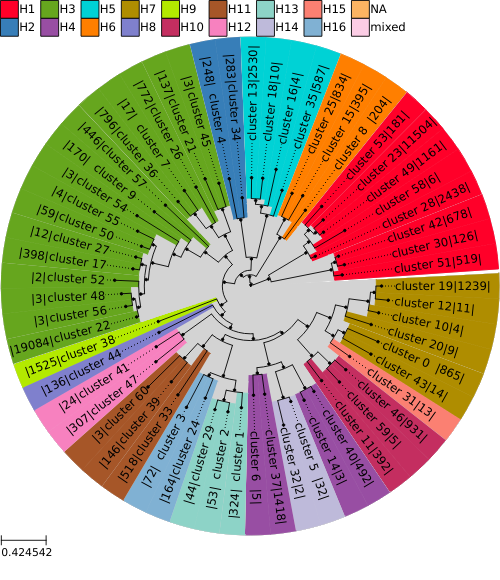

In [56]:
tree, ts = getlocalTree(framelocal, treequery, feature = feature, rownumber = rownumber, prune = prune, treshold = treshold, listcolor = listcolor)
#_ = tree.render(file_name = 'clustertree_degue_220103.pdf', tree_style = ts, w = 500)
_ = tree.render(file_name = 'clustertree_influenza_220103.pdf', tree_style = ts, w = 500)
tree.render(file_name = '%%inline', tree_style = ts, w = 500)

### 3D Plotting

In [57]:
pca3d = PCA(n_components = 3)
matrixpca3d = pca3d.fit_transform(matrixl1)
matrix3d = normalize(matrixpca3d, norm='l2')

In [58]:
frame3d = pd.DataFrame(matrix3d, columns = ['x', 'y', 'z'], index = index)
clust3d = frame3d.join(treequery)#.query('cluster in [58, 52, 42, 49, 37]')
centr3d = clust3d.loc[framecentroid.index.tolist()]#.query('cluster in [58, 52, 42, 49, 37]')

In [59]:
%matplotlib widget

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
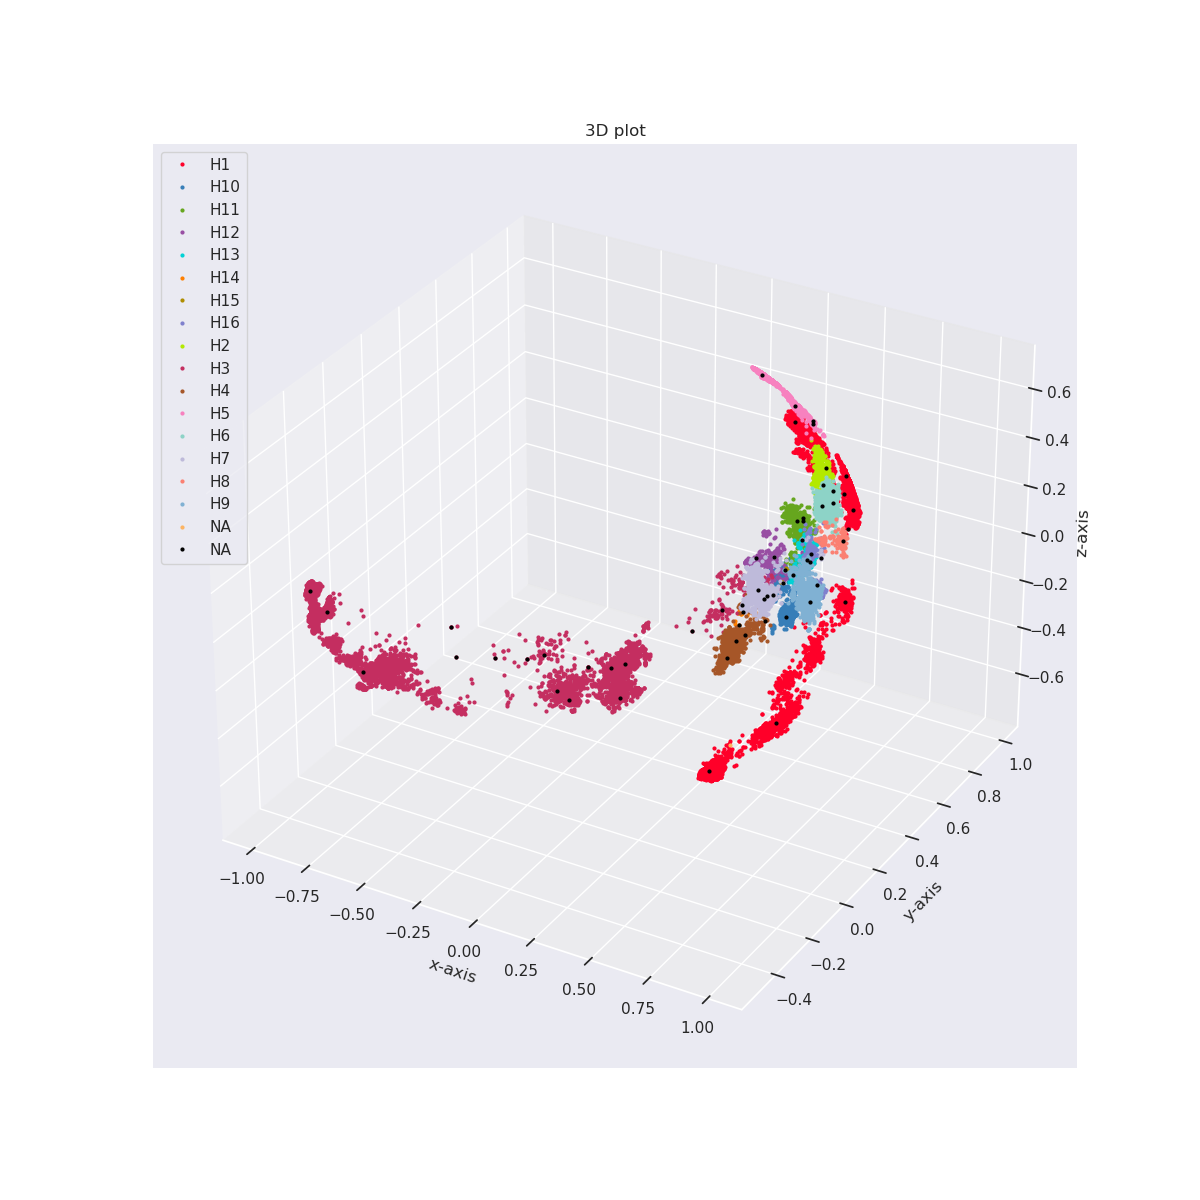

In [60]:
sns.set(style = "darkgrid")
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection = '3d')

#x = meta3d['x']
#y = meta3d['y']
#z = meta3d['z']

ax.set_title("3D plot")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')

#ax.scatter(meta3d.x, meta3d.y, meta3d.z, c = meta3d.H.astype('category'))
#r = 0.5
#u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
#x = np.cos(u) * np.sin(v)
#y = np.sin(u) * np.sin(v)
#z = np.cos(v)
#ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r)

groups = clust3d.groupby(feature)
for i, (name, group) in enumerate(groups):
    plt.plot(group.x, group.y, group.z, marker='o', linestyle='', markersize=2, color = listcolor[i], label=name)
    
plt.plot(centr3d.x, centr3d.y, centr3d.z, marker='o', linestyle='', markersize=2, color = 'black', label=name)

plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
plt.show()
#plt.close()

### Alignment

## Garbage Place